# 6. Linear multiclass classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 6.2 Convert image of handwritten digit to vector

Fetch mnist data from web and convert to numpy.ndarray format

In [2]:
import gzip
import sys
import struct
import urllib.request

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )

In [3]:
data = np.load('mnist.npz')

print("Training data (X):", data['train_x'].shape, data['train_x'].dtype)
print("Training data (Y):", data['train_y'].shape, data['train_y'].dtype)
print("Test data (X):", data['test_x'].shape, data['test_x'].dtype)
print("Test data (Y):", data['test_y'].shape, data['test_y'].dtype)

Training data (X): (60000, 28, 28) float32
Training data (Y): (60000,) uint8
Test data (X): (10000, 28, 28) float32
Test data (Y): (10000,) uint8


In [10]:
def show_instance_img(index, train=True):
    if train:
        x = data['train_x'][index]
        y = data['train_y'][index]
    else:
        x = data['test_x'][index]
        y = data['test_y'][index]

    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f'Gold label: {y}')
    im = ax.imshow(x)
    fig.colorbar(im)
    plt.show()

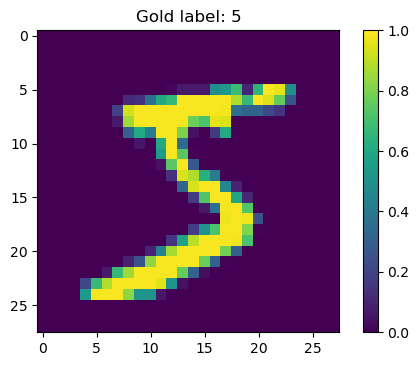

In [11]:
show_instance_img(0)

In [6]:
def images_to_vectors(X):
    # N * 28 * 28 -> N * 784 -> N * 785
    X = np.reshape(X, (X.shape[0], -1))
    return np.c_[X, np.ones(X.shape[0])] # Add bias 

In [7]:
X_train = images_to_vectors(data['train_x'])
X_test = images_to_vectors(data['test_x'])

In [8]:
def show_instance_vec(index, train=True):
    if train:
        x = X_train[index]
        y = data['train_y'][index]
    else:
        x = X_test[index]
        y = data['test_y'][index]

    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(len(x)), x)
    ax.set_title(f'Gold label: {y}')
    ax.set_xlabel('Position')
    ax.set_ylabel('Brightness')
    plt.show()

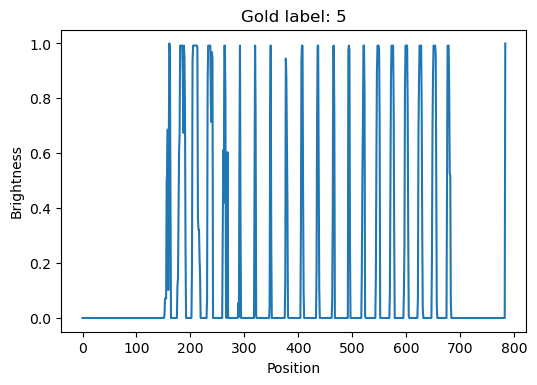

In [9]:
show_instance_vec(0)

In [13]:
print(data['train_x'][0][7][8])
print(X_train[0][204])

0.93333334
0.9333333373069763


## 6.4 Multiclass logistic regression

In [14]:
def softmax(a):
    # a : vector
    amax = np.max(a)
    ea = np.exp(a - amax) # prevent overflow
    return ea / ea.sum()

In [15]:
softmax(np.array([0.1, -0.2, 0.3, -0.4, 0.5]))

array([0.19760595, 0.14639009, 0.24135645, 0.11985407, 0.29479344])

Text(0, 0.5, '$softmax(a)$')

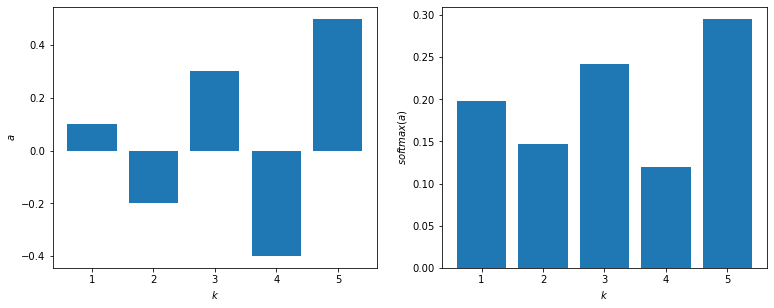

In [17]:
a = np.array([0.1, -0.2, 0.3, -0.4, 0.5])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax1.bar(range(1, 6), a)
ax1.set_xlabel('$k$')
ax1.set_ylabel('$a$')
ax2.bar(range(1, 6), softmax(a))
ax2.set_xlabel('$k$')
ax2.set_ylabel('$softmax(a)$')

## 6.10 Example

In [18]:
from sklearn.linear_model import SGDClassifier

def image_to_vector_nobias(X):
    # N * 28 * 28 -> N * 784
    return np.reshape(X, (len(X), -1))

data = np.load('mnist.npz')
Xtrain = image_to_vector_nobias(data['train_x'])
Ytrain = data['train_y'] # not one-hot encoding
Xtest = image_to_vector_nobias(data['test_x'])
Ytest = data['test_y']

model = SGDClassifier(loss='log') # bias is added automatically in the model
model.fit(Xtrain, Ytrain)

SGDClassifier(loss='log')

In [19]:
print(model.predict(Xtest[0].reshape(1, -1)))
print(Ytest[0])

[7]
7


In [20]:
print(model.predict_proba(Xtest[0].reshape(1, -1)))

[[8.20968798e-05 2.55659328e-10 7.70876577e-04 1.74476913e-02
  9.84952126e-06 3.31805318e-04 3.65432357e-08 9.79761641e-01
  4.42184704e-05 1.55178407e-03]]


In [21]:
# Accuracy
print(model.score(Xtest, Ytest))

0.9153


In [22]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
Ytest_pred = model.predict(Xtest)
confusion_matrix(Ytest, Ytest_pred)

array([[ 963,    0,    1,    2,    0,    2,    6,    2,    1,    3],
       [   0, 1106,    3,    1,    1,    1,    5,    1,   17,    0],
       [   8,    5,  920,   16,   12,    3,   11,    9,   42,    6],
       [   5,    1,   21,  912,    1,   21,    4,   11,   21,   13],
       [   2,    2,    4,    1,  911,    1,    9,    1,    9,   42],
       [  11,    3,    1,   45,   13,  751,   15,    6,   34,   13],
       [  13,    3,    8,    2,    8,   14,  907,    0,    3,    0],
       [   5,   11,   24,    6,    9,    2,    1,  928,    2,   40],
       [  16,    9,    7,   18,   11,   26,    9,    8,  855,   15],
       [  12,    7,    1,   17,   38,   10,    0,   18,    6,  900]],
      dtype=int64)

In [23]:
# Precision, recall, f1 score for each class
from sklearn.metrics import precision_score, recall_score, f1_score
Ytest_pred = model.predict(Xtest)
print(f'precision score fore each class: {precision_score(Ytest, Ytest_pred, average=None)}')
print(f'recall score fore each class: {recall_score(Ytest, Ytest_pred, average=None)}')
print(f'f1 score fore each class: {f1_score(Ytest, Ytest_pred, average=None)}')

precision score fore each class: [0.93043478 0.96425458 0.92929293 0.89411765 0.90737052 0.90373045
 0.93795243 0.94308943 0.86363636 0.87209302]
recall score fore each class: [0.98265306 0.97444934 0.89147287 0.9029703  0.92769857 0.84192825
 0.94676409 0.90272374 0.87782341 0.89197225]
f1 score fore each class: [0.95583127 0.96932515 0.90999011 0.89852217 0.91742195 0.87173535
 0.94233766 0.92246521 0.8706721  0.88192063]


In [25]:
# Macro average precision, recall, f1 score
print(f"macro precision score: {precision_score(Ytest, Ytest_pred, average='macro')}")
print(f"macro recall score: {recall_score(Ytest, Ytest_pred, average='macro')}")
print(f"macro f1 score: {f1_score(Ytest, Ytest_pred, average='macro')}")

macro precision score: 0.91459721472762
macro recall score: 0.9140455876780516
macro f1 score: 0.9140221590165825


In [26]:
# Micro average precision, recall, f1 score
print(f"micro precision score: {precision_score(Ytest, Ytest_pred, average='micro')}")
print(f"micro recall score: {recall_score(Ytest, Ytest_pred, average='micro')}")
print(f"micro f1 score: {f1_score(Ytest, Ytest_pred, average='micro')}")

micro precision score: 0.9153
micro recall score: 0.9153
micro f1 score: 0.9153


<ipython-input-27-930553573d8e>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


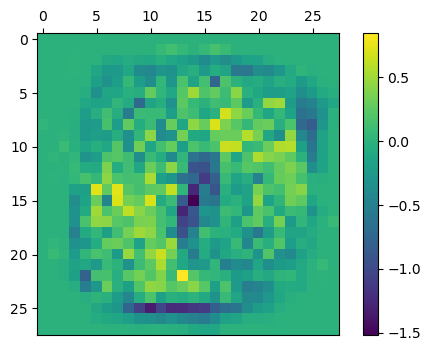

In [27]:
# visualize parameters for class 0
w = model.coef_[0].reshape(28, 28) 

fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.xaxis.tick_top()
im = ax.imshow(w)
fig.colorbar(im, ax=ax)
fig.show()

## 6.11 Exercise

Implement handwritten digit classifier by multiclass logistic regression model with SGD method

In [48]:
def one_hot(Y):
    classnum = 10
    Y_onehot = np.zeros((len(Y), classnum), dtype=np.uint8)
    for i in range(len(Y)):
        Y_onehot[i][Y[i]] = 1
    return Y_onehot


def frobenius_norm(X):
    squared_sum = np.sum(X ** 2)
    return np.sqrt(squared_sum)


def multiclass_logistic_sgd(Xtrain, Ytrain, lr0=0.03, max_epochs=40000, eps=1e-5):
    # Xtrain: N * d
    # Ytrain: N * k
    K = 10 # number of classes
    d = len(Xtrain[0]) # degree of a input
    N = len(Xtrain) # number of instances
    W = np.zeros((K, d))
    
    for t in range(max_epochs):
        lr = lr0 / np.sqrt(t + 1)
        i = np.random.randint(0, N)
        p = softmax(W @ Xtrain[i])
        grad = - ((Ytrain[i] - p).reshape(-1, 1)) @ (Xtrain[i].reshape(1, -1))
        if frobenius_norm(grad) < eps:
            break
        W -= lr * grad
    
    return W, t

In [37]:
data = np.load('mnist.npz')
Xtrain = images_to_vectors(data['train_x'])
Ytrain = one_hot(data['train_y'])
Xtest = images_to_vectors(data['test_x'])
Ytest = one_hot(data['test_y'])

In [52]:
W, t = multiclass_logistic_sgd(Xtrain, Ytrain, max_epochs=400000)

In [58]:
def accuracy(Xtest, Ytest, W):
    correct = 0
    for i in range(len(Xtest)):
        y_hat = W @ Xtest[i]
        argmax = np.argmax(y_hat)
        if Ytest[i][argmax] == 1:
            correct += 1
    return correct / len(Xtest)

In [59]:
accuracy(Xtest, Ytest, W)

0.897

<ipython-input-61-605a03c0a25d>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


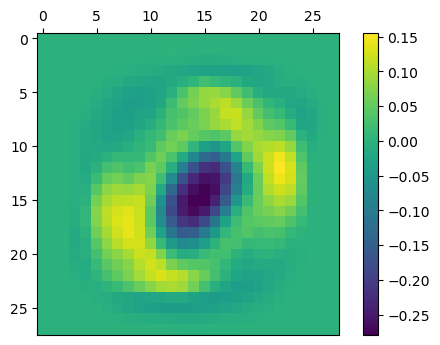

In [61]:
# visualize parameters for class 0
w = W[0][:-1].reshape(28, 28)

fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.xaxis.tick_top()
im = ax.imshow(w)
fig.colorbar(im, ax=ax)
fig.show()